The goal here is to compare methods which fit data with psychometric curves using logistic regression. Indeed, after (long) experiments where for instance you collected sequences of keypresses, it is important to infer at best the parameters of the underlying processes: was the observer biased, was she more precise? While I was *forevever* using [sklearn](https://scikit-learn.org/stable/index.html) and praised it's beautifully crafted methods, I lacked some flexibility in the definition of the model. This notebook was done in collaboration with [Jenna Fradin](https://github.com/jennafradin), master student in the lab.

Here, I define a similar fitting method using [pytorch](https://pytorch.org/) which fits in a few lines of code :

In [1]:
import torch
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
torch.set_default_tensor_type('torch.DoubleTensor')
criterion = torch.nn.BCELoss(reduction='sum')

class LogisticRegressionModel(torch.nn.Module):
    def __init__(self, bias=True, logit0=-1): 
        super(LogisticRegressionModel, self).__init__()
        self.linear = torch.nn.Linear(1, 1, bias=bias)    
        self.logit0 = torch.nn.Parameter(logit0*torch.ones(1))
        
    def forward(self, theta):
        p0 = F.sigmoid(self.logit0)
        out = p0/2 + (1-p0)*F.sigmoid(self.linear(theta))
        return out

learning_rate = 0.01
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2**11 + 1
batch_size=128
gamma = .05 ** (1/num_epochs)

def fit_data(theta, y,
                learning_rate=learning_rate, batch_size=batch_size, gamma=gamma,
                num_epochs=num_epochs, betas=betas,
                verbose=False):

    Theta, labels = torch.Tensor(theta[:, None]), torch.Tensor(y[:, None])
    loader = DataLoader(TensorDataset(Theta, labels), batch_size=batch_size, shuffle=True)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    logistic_model = LogisticRegressionModel()
    logistic_model = logistic_model.to(device)
    logistic_model.train()
    optimizer = torch.optim.Adam(logistic_model.parameters(), lr=learning_rate, betas=betas, amsgrad=False)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma)
    
    for epoch in range(int(num_epochs)):
        logistic_model.train()
        losses = []
        for Theta_, labels_ in loader:
            Theta_, labels_ = Theta_.to(device), labels_.to(device)
            outputs = logistic_model(Theta_)
            loss = criterion(outputs, labels_)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        
        if verbose and (epoch % (num_epochs//32) == 0) : 
            print(f"Iteration: {epoch} - Loss: {np.sum(losses)/len(theta):.5f}")
        scheduler.step()
        
    logistic_model.eval()
    Theta, labels = torch.Tensor(theta[:, None]), torch.Tensor(y[:, None])
    outputs = logistic_model(Theta)
    loss = criterion(outputs, labels).item()/len(theta)
    return logistic_model, loss

and run a series of tests to compare both methods.

<!-- TEASER_END -->

Let's first initialize the notebook:

In [2]:
from pylab import rcParams
#print(rcParams)

In [3]:
fontsize = 20
rcParams['font.size'] = fontsize
rcParams['legend.fontsize'] = fontsize
rcParams['axes.labelsize'] = fontsize
    
import numpy as np
import matplotlib.pyplot as plt

Some hyper parameters which we will tune later:

In [4]:
N = 256
#batch_size = N//4
#batch_size = N//2

N_cv = 10
# N_cv = 2

seed = 42
N_scan = 9
N_test = 2000 # number of points for validation

bias = True

p0 = 0.1       
theta0 = 0.
wt = np.pi/16
theta_std = np.pi/8

## problem statement: a 2aFC task on synthetic data

We will generate a typical setup where we have to guess for the otientation of a visual display compared to the vertical and ask observer to either press on the `left` or `right` arrows. The visual display will be controlled by a $theta$ parameter which we draw randomly according to a Gaussian probability density function. This may be synthesized in the following *psychometric* function:


In [5]:
def psychometric_function(theta, p0=p0, theta0=theta0, wt=wt):
    return p0/2 + (1-p0) / (1+np.exp(-(theta-theta0)/wt))

such that we can draw the data according to:

In [6]:
def get_data(
            N = N,
            p0 = p0,
            theta0 = theta0,
            wt = wt,
            theta_std = theta_std,
            seed=seed):    
    np.random.seed(seed)
    theta = np.random.randn(N)*theta_std
    
    p = psychometric_function(theta, p0, theta0, wt)

    y = np.random.rand(N) < p #generate data
    return theta, p, y

In [7]:
%%timeit
theta, p, y = get_data()

70.4 µs ± 8.73 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [8]:
theta, p, y = get_data()
logistic_model, loss = fit_data(theta, y, verbose=True)
print("Final loss =", loss)

Iteration: 0 - Loss: 0.88468
Iteration: 64 - Loss: 0.55394
Iteration: 128 - Loss: 0.46764
Iteration: 192 - Loss: 0.45594
Iteration: 256 - Loss: 0.45391
Iteration: 320 - Loss: 0.45348
Iteration: 384 - Loss: 0.45334
Iteration: 448 - Loss: 0.45325
Iteration: 512 - Loss: 0.45320
Iteration: 576 - Loss: 0.45311
Iteration: 640 - Loss: 0.45304
Iteration: 704 - Loss: 0.45297
Iteration: 768 - Loss: 0.45290
Iteration: 832 - Loss: 0.45286
Iteration: 896 - Loss: 0.45281
Iteration: 960 - Loss: 0.45275
Iteration: 1024 - Loss: 0.45272
Iteration: 1088 - Loss: 0.45268
Iteration: 1152 - Loss: 0.45266
Iteration: 1216 - Loss: 0.45263
Iteration: 1280 - Loss: 0.45260
Iteration: 1344 - Loss: 0.45258
Iteration: 1408 - Loss: 0.45257
Iteration: 1472 - Loss: 0.45256
Iteration: 1536 - Loss: 0.45254
Iteration: 1600 - Loss: 0.45253
Iteration: 1664 - Loss: 0.45252
Iteration: 1728 - Loss: 0.45251
Iteration: 1792 - Loss: 0.45250
Iteration: 1856 - Loss: 0.45250
Iteration: 1920 - Loss: 0.45249
Iteration: 1984 - Loss: 0.4

In [9]:
print(f'p0 = {p0:.3f}, theta0 = {theta0:.3f}, wt = {wt:.3f}, theta_std = {theta_std:.3f}')

p0 = 0.100, theta0 = 0.000, wt = 0.196, theta_std = 0.785


In [10]:
def get_params(logistic_model, verbose=False):
    theta0_ = -logistic_model.linear.bias.item()/logistic_model.linear.weight.item()
    wt_ = 1/logistic_model.linear.weight.item()
    p0_ = F.sigmoid(logistic_model.logit0).item()
    
    if verbose:
        if bias: print(f'theta0 = {theta0_:.3f}' )
        print(f'slope = {wt_:.3f}')    
        print(f'p0 = {p0_:.3f}')        
    return theta0_, wt_, p0_

theta0_, wt_, p0_ = get_params(logistic_model, verbose=True)

theta0 = 0.037
slope = 0.278
p0 = 0.092


That method is fairly quick, in under 2 seconds:

let's do the same thing with `sklearn`: 

In [11]:
from sklearn.linear_model import LogisticRegression
tol = 1.e-4
C = 3.0
def fit_data_sklearn(theta, y, 
                num_epochs=num_epochs,
                tol=tol, C=C, 
                verbose=False):
    logistic_model = LogisticRegression(solver='liblinear', max_iter=num_epochs, C=C, tol=tol, fit_intercept=True)
    logistic_model.fit(theta[:, None], y)
    
    outputs = logistic_model.predict_proba(theta[:, None])[:, 1]
    outputs_, labels = torch.Tensor(outputs[:, None]), torch.Tensor(y[:, None])
    loss = criterion(outputs_, labels).item()/len(theta)
    if verbose: print("Loss =", loss)
    return logistic_model, loss

In [12]:
logistic_model_sk, loss = fit_data_sklearn(theta, y, verbose=True) 

Loss = 0.4547978375080631


In [13]:
def get_params_sk(logistic_model, verbose=False):
    
    theta0_ = -logistic_model.intercept_[0]/logistic_model.coef_[0][0]
    wt_ = 1/logistic_model.coef_[0][0]

    if verbose:
        if bias: print(f'theta0 = {theta0_:.3f}' )
        print(f'slope = {wt_:.3f}')    
    return theta0_, wt_

theta0_, wt_ = get_params_sk(logistic_model_sk, verbose=True)

theta0 = 0.039
slope = 0.379


That method is *much* quicker:

In [14]:
%%timeit
logistic_model_sk, loss = fit_data_sklearn(theta, y, verbose=False)

991 µs ± 237 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


... but what is the value of few seconds after hours of having observers sitting in front of a screen looking at (often boring) visual displays? More seriously, most important is the reliability of the values which are inferred by each respective method, such that they are correctly reflecting the information contained in the data.

## qualitative comparison of methods

We can synthesize this comparison by drawing a new dataset and plotting the psychometric curves which are obtained by each method

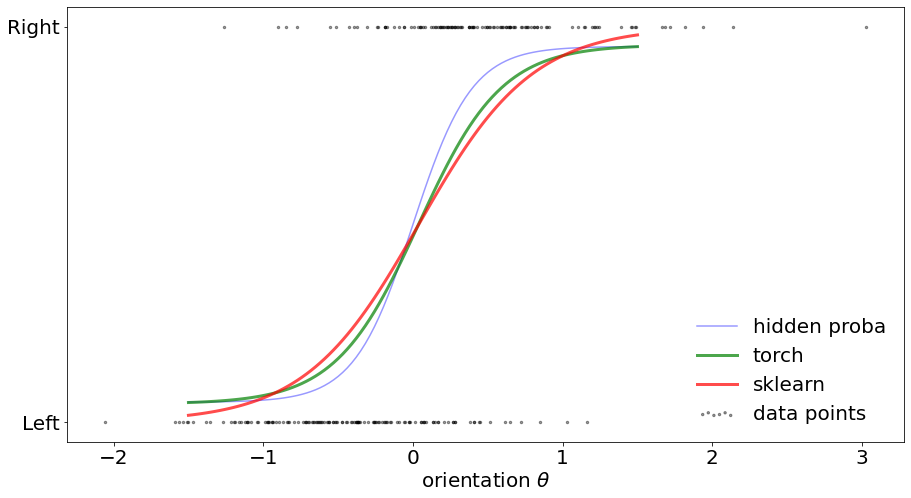

In [15]:
fig, ax = plt.subplots(figsize = (15, 8)) 
ax.scatter(theta, y, s=6, alpha=.4, color = 'k', label='data points')
# ax.scatter(theta, p, s=6, alpha=.4, color = 'b', label='hidden proba')
x_values = np.linspace(-1.5, 1.50, 100)[:, None]
y_values_p = psychometric_function(x_values, p0, theta0, wt)
ax.plot(x_values, y_values_p, alpha=.4, color = 'b', label='hidden proba')
y_values = logistic_model(torch.Tensor(x_values)).detach().numpy()
ax.plot(x_values, y_values, 'g', alpha=.7, lw=3, label='torch')
y_values_sk = logistic_model_sk.predict_proba(x_values)[:, 1]
ax.plot(x_values, y_values_sk, 'r', alpha=.7, lw=3, label='sklearn')
ax.set_xlabel(r'orientation $\theta$', fontsize=20)
ax.set_yticks([0.,1.])
ax.set_yticklabels(['Left', 'Right'], fontsize=20)
plt.legend(fontsize=20, frameon=False, scatterpoints=6);

The losses which were computed above are those obtained during training. Relying on this value may be a dangerous strategy as the model may be overfitting the data. We should therefore measure how the model would generalize with novel data.

While it hard to do with real (experimental) data which are often scarse, here we synthesized the data and we can thus compute a testing loss by drawing again a set of new data and computing the loss on that data:

In [16]:
theta, p, y = get_data(N=N_test, seed=seed+N_test)    

In [17]:
def loss_true(theta, p, y):
    labels = torch.Tensor(y[:, None])        
    P = torch.Tensor(p[:, None])
    return criterion(P, labels).item()/len(theta)
print(f'Testing true loss = {loss_true(theta, p, y):.3f}')

Testing true loss = 0.404


In [18]:
logistic_model, loss = fit_data(theta, y, verbose=False)
print(f'Training loss = {loss:.3f}')

Training loss = 0.403


In [19]:
def loss_torch(logistic_model, theta, p, y):
    labels = torch.Tensor(y[:, None])
    Theta = torch.Tensor(theta[:, None])
    P = torch.Tensor(p[:, None])

    outputs = logistic_model(Theta)
    return criterion(outputs, labels).item()/len(theta)
print(f'Testing loss = {loss_torch(logistic_model, theta, p, y):.3f}')

Testing loss = 0.403


In [20]:
logistic_model_sk, loss_sk = fit_data_sklearn(theta, y, verbose=False)
print(f'Training sklearn loss = {loss_sk:.3f}')

Training sklearn loss = 0.411


In [21]:
def loss_sklearn(logistic_model, theta, p, y):
    outputs = logistic_model.predict_proba(theta[:, None])[:, 1]
    outputs_, labels = torch.Tensor(outputs[:, None]), torch.Tensor(y[:, None])
    return criterion(outputs_, labels).item()/len(theta)

print(f'Testing sklearn loss = {loss_sklearn(logistic_model_sk, theta, p, y):.3f}')

Testing sklearn loss = 0.411



## quantitative comparison of methods : varrying methods' parameters

Let's study the influence of each method's meta-parameter, such as the number of iterations:

### influence of learning rate


In [22]:
learning_rates = learning_rate * np.logspace(-1, 1, N_scan, base=10)
learning_rates_, losses, loss_Ps = [], [], []
for learning_rate_ in learning_rates:
    for i_CV in range(N_cv):
        theta, p, y = get_data(seed=seed+i_CV)

        logistic_model, loss = fit_data(theta, y, learning_rate=learning_rate_, verbose=False)        

        if N_test>0:
            theta, p, y = get_data(N=N_test, seed=seed+i_CV+N_test)
            loss = loss_torch(logistic_model, theta, p, y)            
        loss_P = loss_true(theta, p, y)
        
        if i_CV==0: 
            print(f"learning_rate: {learning_rate_:.5f}, Loss: {loss:.5f}, loss_P: {loss_P:.5f}")
        learning_rates_.append(learning_rate_)
        loss_Ps.append(loss_P/loss_P)
        losses.append(loss/loss_P)

learning_rate: 0.00200, Loss: 0.48911, loss_P: 0.40406
learning_rate: 0.00356, Loss: 0.42687, loss_P: 0.40406
learning_rate: 0.00632, Loss: 0.41186, loss_P: 0.40406
learning_rate: 0.01125, Loss: 0.40816, loss_P: 0.40406
learning_rate: 0.02000, Loss: 0.40730, loss_P: 0.40406
learning_rate: 0.03557, Loss: 0.40725, loss_P: 0.40406
learning_rate: 0.06325, Loss: 0.40723, loss_P: 0.40406
learning_rate: 0.11247, Loss: 0.40724, loss_P: 0.40406
learning_rate: 0.20000, Loss: 0.40722, loss_P: 0.40406


In [23]:
opts = dict(marker='.', lw=0, alpha=3/N_cv, ms=20)

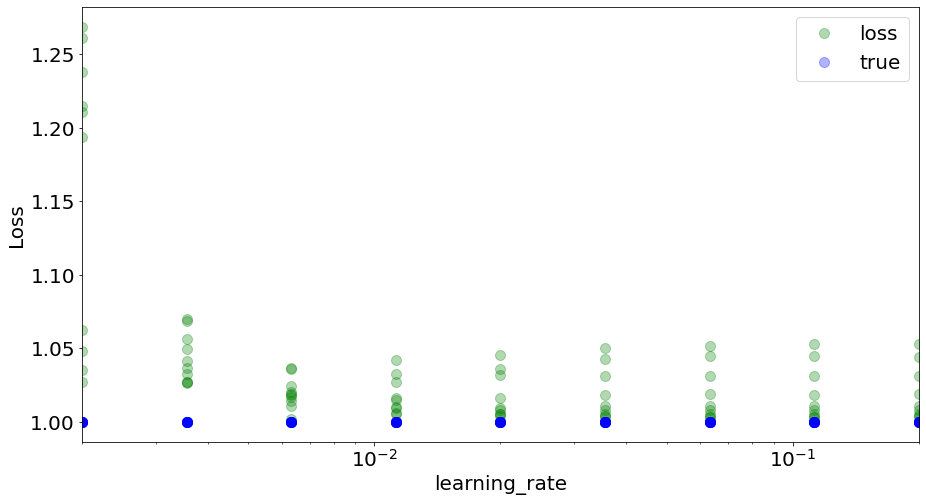

In [24]:
#influence du learning rate sur loss

fig, ax = plt.subplots(figsize = (15, 8))
ax.plot(learning_rates_, losses, **opts, color='green', label='loss')
ax.plot(learning_rates_, loss_Ps, **opts, color='blue', label='true')

ax.set_xlim(np.min(learning_rates_), np.max(learning_rates_))

ax.set_xlabel('learning_rate')
ax.set_ylabel('Loss')
ax.set_xscale('log')
ax.legend(loc='best');

### influence du nombre d'epochs

In [25]:
num_epochss = num_epochs * np.logspace(-2, 0, N_scan, base=10)
num_epochss_, losses, loss_Ps, loss_SKLs = [], [], [], []
for num_epochs_ in num_epochss:
    for i_CV in range(N_cv):
        
        theta, p, y = get_data(seed=seed+i_CV)
        logistic_model, loss = fit_data(theta, y, num_epochs=int(num_epochs_), verbose=False)
        logistic_model_sk, loss_SKL = fit_data_sklearn(theta, y, num_epochs=int(num_epochs_), verbose=False)
        
        if N_test>0:
            theta, p, y = get_data(N=N_test, seed=seed+i_CV+N_test)
            loss = loss_torch(logistic_model, theta, p, y)            
            loss_SKL = loss_sklearn(logistic_model_sk, theta, p, y)
        loss_P = loss_true(theta, p, y)
                
        if i_CV==0: 
            print(f"num_epochs: {int(num_epochs_)}, Loss: {loss:.5f}, loss_P: {loss_P:.5f}, loss_SKL: {loss_SKL:.5f}")
        num_epochss_.append(num_epochs_)
        loss_SKLs.append(loss_SKL/loss_P)
        loss_Ps.append(loss_P/loss_P)
        losses.append(loss/loss_P)

num_epochs: 204, Loss: 0.41235, loss_P: 0.40406, loss_SKL: 0.41568
num_epochs: 364, Loss: 0.40892, loss_P: 0.40406, loss_SKL: 0.41568
num_epochs: 647, Loss: 0.40983, loss_P: 0.40406, loss_SKL: 0.41568
num_epochs: 1152, Loss: 0.40754, loss_P: 0.40406, loss_SKL: 0.41568
num_epochs: 2049, Loss: 0.40732, loss_P: 0.40406, loss_SKL: 0.41568
num_epochs: 3643, Loss: 0.40726, loss_P: 0.40406, loss_SKL: 0.41568
num_epochs: 6479, Loss: 0.40726, loss_P: 0.40406, loss_SKL: 0.41568
num_epochs: 11522, Loss: 0.40736, loss_P: 0.40406, loss_SKL: 0.41568
num_epochs: 20490, Loss: 0.40735, loss_P: 0.40406, loss_SKL: 0.41568


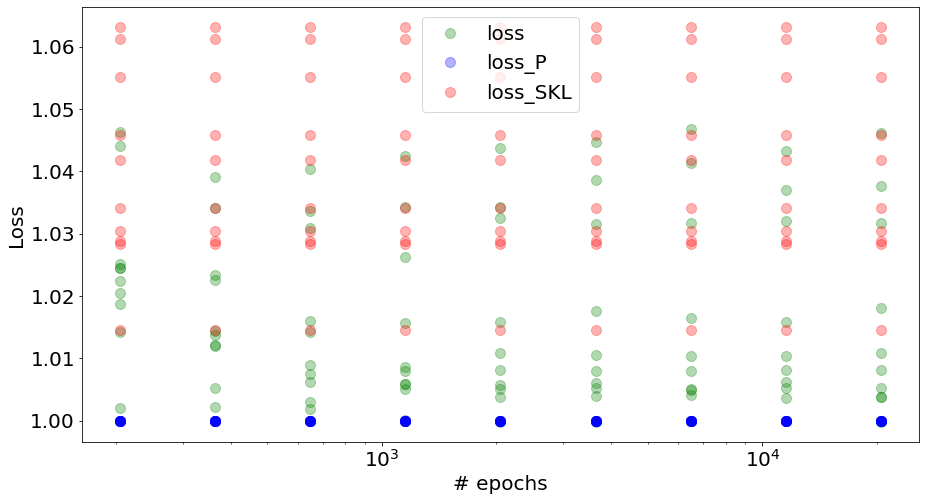

In [26]:
# influence du nbr d'epochs sur loss 
fig, ax = plt.subplots(figsize = (15, 8)) 
ax.plot(num_epochss_, losses, **opts, color='green', label='loss')
ax.plot(num_epochss_, loss_Ps, **opts, color='blue', label='loss_P')
ax.plot(num_epochss_, loss_SKLs, **opts, color='red', label='loss_SKL')

ax.set_xlabel('# epochs')
ax.set_ylabel('Loss')
ax.set_xscale('log')
ax.legend(loc='best');

### influence of minibatch size

In [27]:
batch_sizes = N * np.logspace(-3, 0, N_scan, base=2)
batch_sizes_, losses, loss_Ps = [], [], []
for batch_size_ in batch_sizes:
    for i_CV in range(N_cv):
        theta, p, y = get_data(seed=seed+i_CV)

        logistic_model, loss = fit_data(theta, y, batch_size=int(batch_size_), verbose=False)

        if N_test>0:
            theta, p, y = get_data(N=N_test, seed=seed+i_CV+N_test)
            loss = loss_torch(logistic_model, theta, p, y)            
        loss_P = loss_true(theta, p, y)
        
        if i_CV==0: 
            print(f"batch_size: {int(batch_size_)}, Loss: {loss:.5f}, loss_P: {loss_P:.5f}, loss_SKL: {loss_SKL:.5f}")
        batch_sizes_.append(batch_size_)
        loss_Ps.append(loss_P/loss_P)
        losses.append(loss/loss_P)

batch_size: 32, Loss: 0.40722, loss_P: 0.40406, loss_SKL: 0.41219
batch_size: 41, Loss: 0.40725, loss_P: 0.40406, loss_SKL: 0.41219
batch_size: 53, Loss: 0.40724, loss_P: 0.40406, loss_SKL: 0.41219
batch_size: 69, Loss: 0.40724, loss_P: 0.40406, loss_SKL: 0.41219
batch_size: 90, Loss: 0.40730, loss_P: 0.40406, loss_SKL: 0.41219
batch_size: 117, Loss: 0.40724, loss_P: 0.40406, loss_SKL: 0.41219
batch_size: 152, Loss: 0.40730, loss_P: 0.40406, loss_SKL: 0.41219
batch_size: 197, Loss: 0.40732, loss_P: 0.40406, loss_SKL: 0.41219
batch_size: 256, Loss: 0.40959, loss_P: 0.40406, loss_SKL: 0.41219


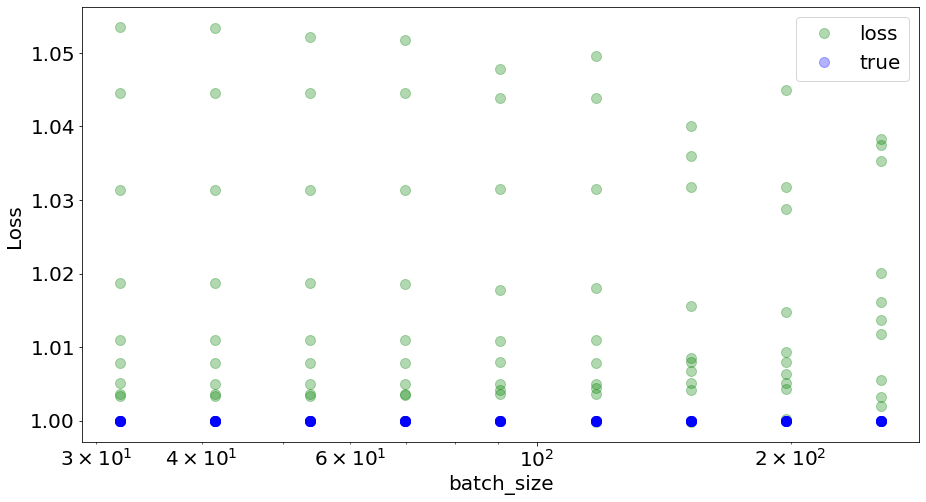

In [28]:
# influence de la taille du minibatch sur loss 

fig, ax = plt.subplots(figsize = (15, 8)) 
ax.plot(batch_sizes_, losses, **opts, color='green', label='loss')
ax.plot(batch_sizes_, loss_Ps, **opts, color='blue', label='true')

ax.set_xlabel('batch_size')
ax.set_ylabel('Loss ')
ax.set_xscale('log')
ax.legend(loc='best');

### influence of `beta1`

In [29]:
beta1s = 1. - np.logspace(-3, -1, N_scan, base=10, endpoint=True)
beta1s_, losses, loss_Ps = [], [], []
for beta1_ in beta1s:
    for i_CV in range(N_cv):
        theta, p, y = get_data(seed=seed+i_CV)
        
        logistic_model, loss = fit_data(theta, y, betas=(beta1_, beta2), verbose=False)

        if N_test>0:
            theta, p, y = get_data(N=N_test, seed=seed+i_CV+N_test)
            loss = loss_torch(logistic_model, theta, p, y)            
        loss_P = loss_true(theta, p, y)

        if i_CV==0: 
            print(f"beta1: {beta1_}, Loss: {loss:.5f}, loss_P: {loss_P:.5f}")
        beta1s_.append(beta1_)
        loss_Ps.append(loss_P/loss_P)
        losses.append(loss/loss_P)

beta1: 0.999, Loss: 0.41349, loss_P: 0.40406
beta1: 0.9982217205899611, Loss: 0.40813, loss_P: 0.40406
beta1: 0.9968377223398316, Loss: 0.40725, loss_P: 0.40406
beta1: 0.9943765867480965, Loss: 0.40734, loss_P: 0.40406
beta1: 0.99, Loss: 0.40735, loss_P: 0.40406
beta1: 0.9822172058996108, Loss: 0.40727, loss_P: 0.40406
beta1: 0.9683772233983162, Loss: 0.40757, loss_P: 0.40406
beta1: 0.9437658674809651, Loss: 0.40761, loss_P: 0.40406
beta1: 0.9, Loss: 0.40768, loss_P: 0.40406


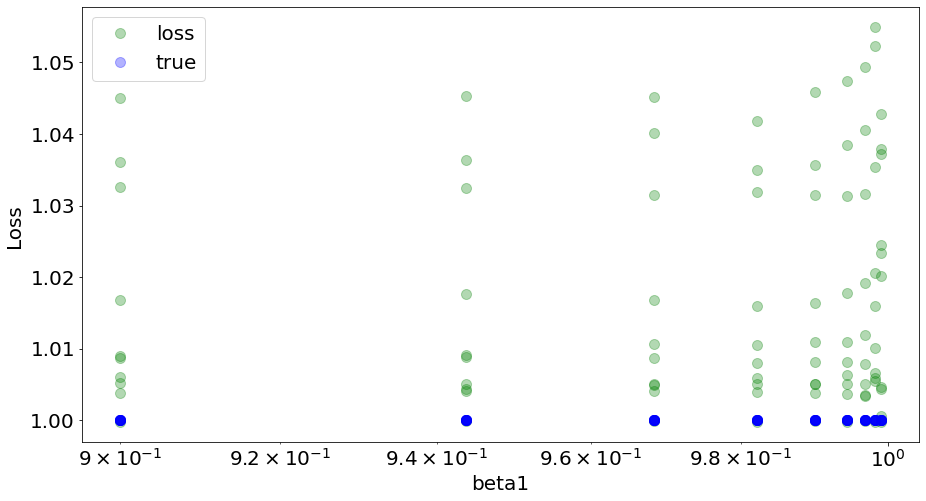

In [30]:
fig, ax = plt.subplots(figsize = (15, 8)) 
ax.plot(beta1s_, losses, **opts, color='green', label='loss')
ax.plot(beta1s_, loss_Ps, **opts, color='blue', label='true')

ax.set_xlabel('beta1')
ax.set_ylabel('Loss ')
ax.set_xscale('log')
ax.legend(loc='best');

### influence of `beta2`

In [31]:
beta2s = 1. - np.logspace(-3, -1, N_scan, base=10, endpoint=True)
beta2s_, losses, loss_Ps = [], [], []
for beta2_ in beta2s:
    for i_CV in range(N_cv):
        theta, p, y = get_data(seed=seed+i_CV)

        logistic_model, loss = fit_data(theta, y, betas=(beta1, beta2_), verbose=False)

        if N_test>0:
            theta, p, y = get_data(N=N_test, seed=seed+i_CV+N_test)
            loss = loss_torch(logistic_model, theta, p, y)            
        loss_P = loss_true(theta, p, y)
        
        if i_CV==0: 
            print(f"beta2: {beta2_}, Loss: {loss:.5f}, loss_P: {loss_P:.5f}")
        beta2s_.append(beta2_)
        loss_Ps.append(loss_P/loss_P)
        losses.append(loss/loss_P)

beta2: 0.999, Loss: 0.40771, loss_P: 0.40406
beta2: 0.9982217205899611, Loss: 0.40729, loss_P: 0.40406
beta2: 0.9968377223398316, Loss: 0.40729, loss_P: 0.40406
beta2: 0.9943765867480965, Loss: 0.40726, loss_P: 0.40406
beta2: 0.99, Loss: 0.40725, loss_P: 0.40406
beta2: 0.9822172058996108, Loss: 0.40724, loss_P: 0.40406
beta2: 0.9683772233983162, Loss: 0.40724, loss_P: 0.40406
beta2: 0.9437658674809651, Loss: 0.40724, loss_P: 0.40406
beta2: 0.9, Loss: 0.40723, loss_P: 0.40406


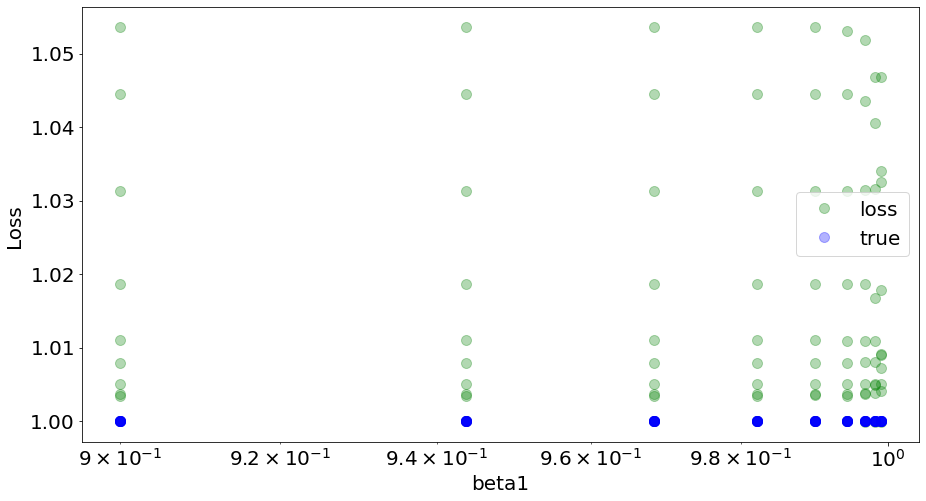

In [32]:
fig, ax = plt.subplots(figsize = (15, 8)) 
ax.plot(beta2s_, losses, **opts, color='green', label='loss')
ax.plot(beta2s_, loss_Ps, **opts, color='blue', label='true')

ax.set_xlabel('beta1')
ax.set_ylabel('Loss ')
ax.set_xscale('log')
ax.legend(loc='best');

### influence of `C`

In [33]:
Cs = C * np.logspace(-2, 2, N_scan, base=4)
Cs_, loss_Ps, loss_SKLs = [], [], []
for C_ in Cs:
    for i_CV in range(N_cv):
        theta, p, y = get_data(seed=seed+i_CV)

        logistic_model_sk, loss_SKL = fit_data_sklearn(theta, y, C=C_, verbose=False)

        if N_test>0:
            theta, p, y = get_data(N=N_test, seed=seed+i_CV+N_test)
            loss_SKL = loss_sklearn(logistic_model_sk, theta, p, y)
        loss_P = loss_true(theta, p, y)

        if i_CV==0: 
            print(f"C: {C_}, Loss: {loss:.5f}, loss_SKL: {loss_SKL:.5f}")
            
        Cs_.append(C_)
        loss_SKLs.append(loss_SKL/loss_P)
        loss_Ps.append(loss_P/loss_P)

C: 0.1875, Loss: 0.41076, loss_SKL: 0.44070
C: 0.375, Loss: 0.41076, loss_SKL: 0.42742
C: 0.75, Loss: 0.41076, loss_SKL: 0.42055
C: 1.5, Loss: 0.41076, loss_SKL: 0.41724
C: 3.0, Loss: 0.41076, loss_SKL: 0.41568
C: 6.0, Loss: 0.41076, loss_SKL: 0.41495
C: 12.0, Loss: 0.41076, loss_SKL: 0.41460
C: 24.0, Loss: 0.41076, loss_SKL: 0.41443
C: 48.0, Loss: 0.41076, loss_SKL: 0.41434


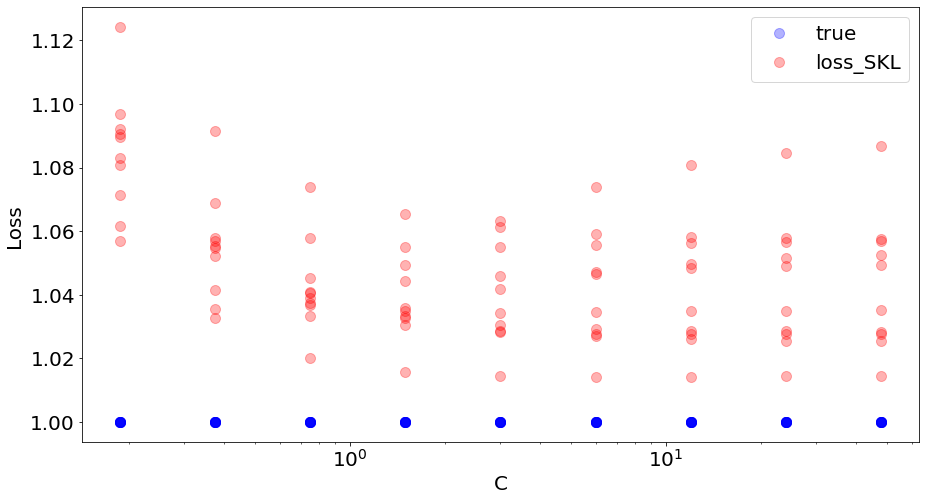

In [34]:
fig, ax = plt.subplots(figsize = (15, 8)) 
ax.plot(Cs_, loss_Ps, **opts, color='blue', label='true')
ax.plot(Cs_, loss_SKLs, **opts, color='red', label='loss_SKL')

ax.set_xlabel('C')
ax.set_ylabel('Loss ')
ax.set_xscale('log')
ax.legend(loc='best');

### influence of `tol`

In [35]:
tols = tol * np.logspace(-2, 2, N_scan, base=10)
tols_, loss_Ps, loss_SKLs = [], [], []
for tol_ in tols:
    for i_CV in range(N_cv):
        theta, p, y = get_data(seed=seed+i_CV)

        logistic_model_sk, loss_SKL = fit_data_sklearn(theta, y, tol=tol_, verbose=False)
        
        if N_test>0:
            theta, p, y = get_data(N=N_test, seed=seed+i_CV+N_test)
            loss_SKL = loss_sklearn(logistic_model_sk, theta, p, y)
        loss_P = loss_true(theta, p, y)

        if i_CV==0: 
            print(f"tol: {tol_}, Loss: {loss:.5f}, loss_SKL: {loss_SKL:.5f}")
        tols_.append(tol_)
        loss_SKLs.append(loss_SKL/loss_P)
        loss_Ps.append(loss_P/loss_P)

tol: 1.0000000000000002e-06, Loss: 0.41076, loss_SKL: 0.41568
tol: 3.162277660168379e-06, Loss: 0.41076, loss_SKL: 0.41568
tol: 1e-05, Loss: 0.41076, loss_SKL: 0.41568
tol: 3.1622776601683795e-05, Loss: 0.41076, loss_SKL: 0.41568
tol: 0.0001, Loss: 0.41076, loss_SKL: 0.41568
tol: 0.000316227766016838, Loss: 0.41076, loss_SKL: 0.41568
tol: 0.001, Loss: 0.41076, loss_SKL: 0.41569
tol: 0.0031622776601683794, Loss: 0.41076, loss_SKL: 0.41569
tol: 0.01, Loss: 0.41076, loss_SKL: 0.41609


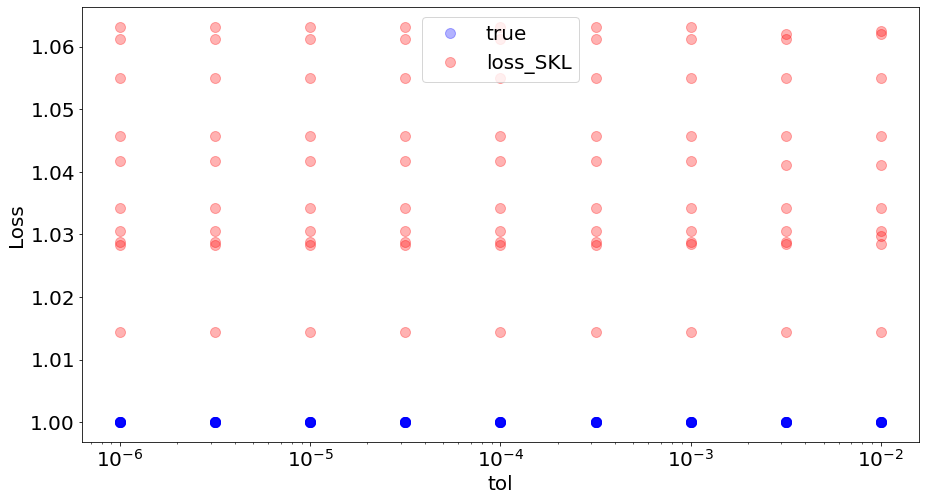

In [36]:
fig, ax = plt.subplots(figsize = (15, 8)) 
ax.plot(tols_, loss_Ps, **opts, color='blue', label='true')
ax.plot(tols_, loss_SKLs, **opts, color='red', label='loss_SKL')

ax.set_xlabel('tol')
ax.set_ylabel('Loss')
ax.set_xscale('log')
ax.legend(loc='best');


## quantitative comparison of methods : varrying experimental parameters


### influence of number of trials

In [37]:
Ns = np.logspace(1.5, 3, N_scan, base=10, endpoint=True)

Ns_, losses, loss_Ps, loss_SKLs = [], [], [], []

for N_ in Ns:
    for i_CV in range(N_cv):
        theta, p, y = get_data(N=int(N_), seed=seed+i_CV)
        
        logistic_model, loss = fit_data(theta, y, verbose=False)
        logistic_model_sk, loss_SKL = fit_data_sklearn(theta, y, verbose=False)

        if N_test>0:
            theta, p, y = get_data(N=N_test, seed=seed+i_CV+N_test)
            loss = loss_torch(logistic_model, theta, p, y)            
            loss_SKL = loss_sklearn(logistic_model_sk, theta, p, y)
        loss_P = loss_true(theta, p, y)

        if i_CV==0: print(f"N: {int(N_)}, Loss: {loss:.5f}, loss_P: {loss_P:.5f}, loss_SKL: {loss_SKL:.5f}")
        loss_SKLs.append(loss_SKL/loss_P)
        Ns_.append(N_)
        loss_Ps.append(loss_P/loss_P)
        losses.append(loss/loss_P)
    

N: 10, Loss: 0.57260, loss_P: 0.40406, loss_SKL: 0.50810
N: 17, Loss: 0.46186, loss_P: 0.40406, loss_SKL: 0.46449
N: 31, Loss: 0.41130, loss_P: 0.40406, loss_SKL: 0.42549
N: 56, Loss: 0.41526, loss_P: 0.40406, loss_SKL: 0.41160
N: 100, Loss: 0.41090, loss_P: 0.40406, loss_SKL: 0.41488
N: 177, Loss: 0.40565, loss_P: 0.40406, loss_SKL: 0.41248
N: 316, Loss: 0.41154, loss_P: 0.40406, loss_SKL: 0.41416
N: 562, Loss: 0.40575, loss_P: 0.40406, loss_SKL: 0.41183
N: 1000, Loss: 0.40577, loss_P: 0.40406, loss_SKL: 0.41207


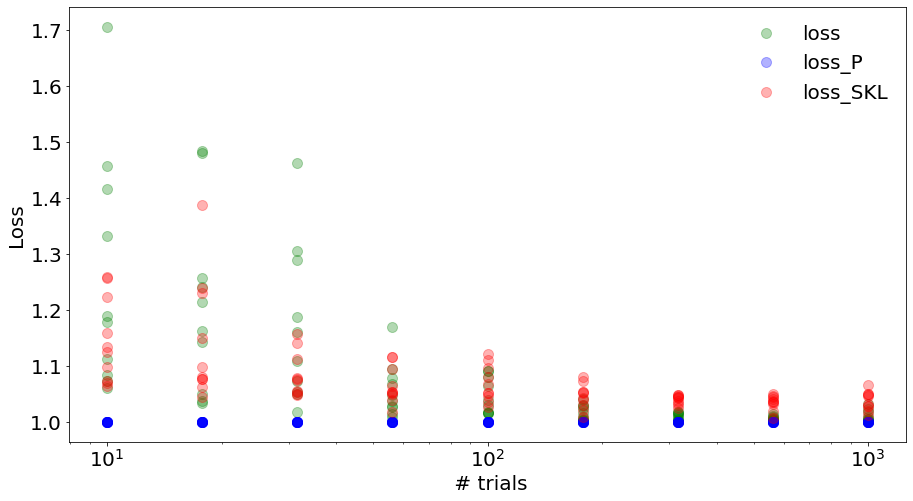

In [38]:
fig, ax = plt.subplots(figsize = (15, 8)) 
ax.plot(Ns_, losses, **opts, color='green', label='loss')
ax.plot(Ns_, loss_Ps, **opts, color='blue', label='loss_P')
ax.plot(Ns_, loss_SKLs, **opts, color='red', label='loss_SKL')

ax.set_xlabel(' # trials')
ax.set_ylabel('Loss')
ax.set_xscale('log')
plt.legend(fontsize=20, frameon=False, scatterpoints=6);

### influence of number of theta_std


The convergence of the fitting procedure may also depend on the parametrers of the data which were set to:

In [39]:
print(f'p0 = {p0:.3f}, theta0 = {theta0:.3f}, wt = {wt:.3f}, theta_std = {theta_std:.3f}')

p0 = 0.100, theta0 = 0.000, wt = 0.196, theta_std = 0.785


In [40]:
theta_stds = theta_std * np.logspace(-1, 1, N_scan, base=2, endpoint=True)

theta_stds_, losses, loss_Ps, loss_SKLs = [], [], [], []

for theta_std_ in theta_stds:
    for i_CV in range(N_cv):
        theta, p, y = get_data(theta_std=theta_std_, seed=seed+i_CV)
        
        logistic_model, loss = fit_data(theta, y, verbose=False)
        logistic_model_sk, loss_SKL = fit_data_sklearn(theta, y, verbose=False)

        if N_test>0:
            theta, p, y = get_data(theta_std=theta_std_, N=N_test, seed=seed+i_CV+N_test)
            loss = loss_torch(logistic_model, theta, p, y)            
            loss_SKL = loss_sklearn(logistic_model_sk, theta, p, y)
        loss_P = loss_true(theta, p, y)

        if i_CV==0: print(f"theta_std: {theta_std_:.3f}, Loss: {loss:.5f}, loss_P: {loss_P:.5f}, loss_SKL: {loss_SKL:.5f}")
        loss_SKLs.append(loss_SKL/loss_P)
        theta_stds_.append(theta_std_)
        loss_Ps.append(loss_P/loss_P)
        losses.append(loss/loss_P)
    

theta_std: 0.393, Loss: 0.52163, loss_P: 0.52184, loss_SKL: 0.52314
theta_std: 0.467, Loss: 0.49353, loss_P: 0.49074, loss_SKL: 0.49581
theta_std: 0.555, Loss: 0.46422, loss_P: 0.46083, loss_SKL: 0.46657
theta_std: 0.660, Loss: 0.43984, loss_P: 0.43457, loss_SKL: 0.44306
theta_std: 0.785, Loss: 0.40737, loss_P: 0.40406, loss_SKL: 0.41568
theta_std: 0.934, Loss: 0.36932, loss_P: 0.36431, loss_SKL: 0.38329
theta_std: 1.111, Loss: 0.34172, loss_P: 0.33772, loss_SKL: 0.36246
theta_std: 1.321, Loss: 0.33110, loss_P: 0.32657, loss_SKL: 0.35530
theta_std: 1.571, Loss: 0.31559, loss_P: 0.30983, loss_SKL: 0.34548


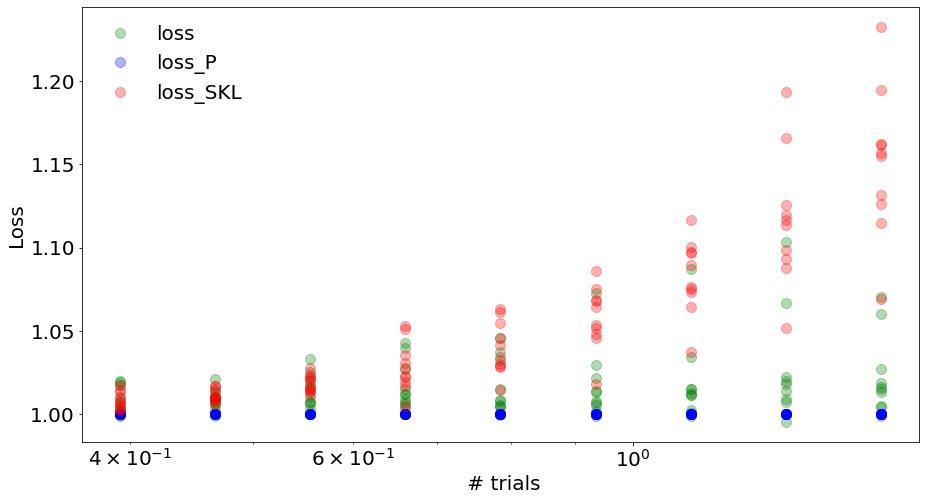

In [41]:
fig, ax = plt.subplots(figsize = (15, 8)) 
ax.plot(theta_stds_, losses, **opts, color='green', label='loss')
ax.plot(theta_stds_, loss_Ps, **opts, color='blue', label='loss_P')
ax.plot(theta_stds_, loss_SKLs, **opts, color='red', label='loss_SKL')

ax.set_xlabel('theta_std')
ax.set_ylabel('Loss')
ax.set_xscale('log')
plt.legend(fontsize=20, frameon=False, scatterpoints=6);

### influence of number of `p0`



In [42]:
p0s = np.logspace(-3, -.7, N_scan, base=10, endpoint=True)

p0s_, losses, loss_Ps, loss_SKLs = [], [], [], []

for p0_ in p0s:
    for i_CV in range(N_cv):
        theta, p, y = get_data(p0=p0_, seed=seed+i_CV)
        
        logistic_model, loss = fit_data(theta, y, verbose=False)
        logistic_model_sk, loss_SKL = fit_data_sklearn(theta, y, verbose=False)
        
        if N_test>0:
            theta, p, y = get_data(p0=p0_, N=N_test, seed=seed+i_CV)
            loss = loss_torch(logistic_model, theta, p, y)
            loss_SKL = loss_sklearn(logistic_model_sk, theta, p, y)
        loss_P = loss_true(theta, p, y)
        
        if i_CV==0: print(f"theta_std: {theta_std_:.3f}, Loss: {loss:.5f}, loss_P: {loss_P:.5f}, loss_SKL: {loss_SKL:.5f}")
        loss_SKLs.append(loss_SKL/loss_P)
        p0s_.append(p0_)
        loss_Ps.append(loss_P/loss_P)
        losses.append(loss/loss_P)
    

theta_std: 1.571, Loss: 0.31496, loss_P: 0.31241, loss_SKL: 0.31751
theta_std: 1.571, Loss: 0.31686, loss_P: 0.31459, loss_SKL: 0.31924
theta_std: 1.571, Loss: 0.31817, loss_P: 0.31605, loss_SKL: 0.32082
theta_std: 1.571, Loss: 0.32088, loss_P: 0.31868, loss_SKL: 0.32352
theta_std: 1.571, Loss: 0.33361, loss_P: 0.33105, loss_SKL: 0.33616
theta_std: 1.571, Loss: 0.34562, loss_P: 0.34155, loss_SKL: 0.34760
theta_std: 1.571, Loss: 0.36740, loss_P: 0.35756, loss_SKL: 0.37215
theta_std: 1.571, Loss: 0.41381, loss_P: 0.40411, loss_SKL: 0.42447
theta_std: 1.571, Loss: 0.47626, loss_P: 0.46432, loss_SKL: 0.49337


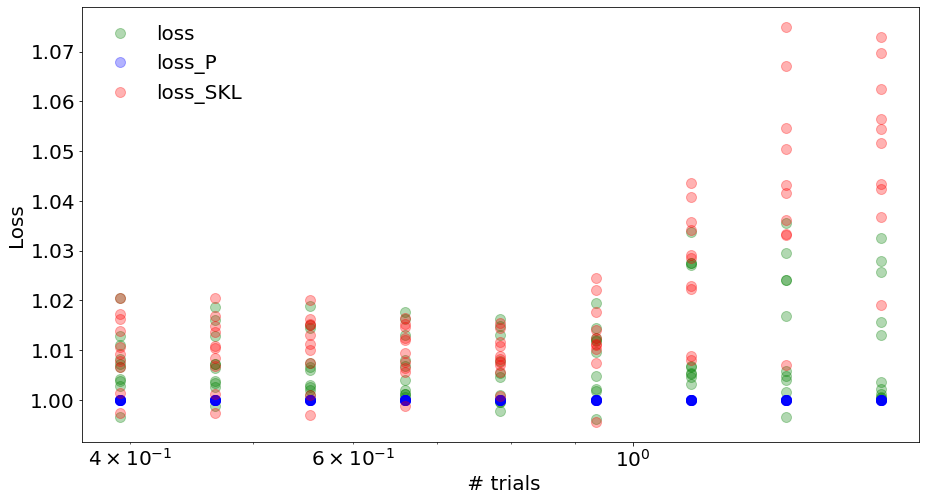

In [43]:
fig, ax = plt.subplots(figsize = (15, 8)) 
ax.plot(p0s_, losses, **opts, color='green', label='loss')
ax.plot(p0s_, loss_Ps, **opts, color='blue', label='loss_P')
ax.plot(p0s_, loss_SKLs, **opts, color='red', label='loss_SKL')

ax.set_xlabel('p0')
ax.set_ylabel('Loss')
ax.set_xscale('log')
plt.legend(fontsize=20, frameon=False, scatterpoints=6);



## comparing the predicted values


In [44]:
print(f'p0 = {p0:.3f}, theta0 = {theta0:.3f}, wt = {wt:.3f}, theta_std = {theta_std:.3f}')

p0 = 0.100, theta0 = 0.000, wt = 0.196, theta_std = 0.785




### changing `p0`


In [45]:
N_scan = 20
p0s = np.logspace(-3, -.7, N_scan, base=10, endpoint=True)

p0s_, wts_, theta0s_, p0_tos, theta0_tos, theta0_sks, wt_tos, wt_sks = [], [], [], [], [], [], [], []

for p0_ in p0s:
    for i_CV in range(N_cv):
        theta, p, y = get_data(p0=p0_, seed=seed+i_CV)
        
        logistic_model, loss = fit_data(theta, y, verbose=False)
        logistic_model_sk, loss_SKL = fit_data_sklearn(theta, y, verbose=False)
        
        theta0_to, wt_to, p0_to = get_params(logistic_model, verbose=False)
        theta0_sk, wt_sk = get_params_sk(logistic_model_sk, verbose=False)
        
        p0s_.append(p0_)
        theta0s_.append(theta0)
        wts_.append(wt)
        p0_tos.append(p0_to)
        theta0_tos.append(theta0_to)
        theta0_sks.append(theta0_sk)
        wt_tos.append(wt_to)
        wt_sks.append(wt_sk)
    

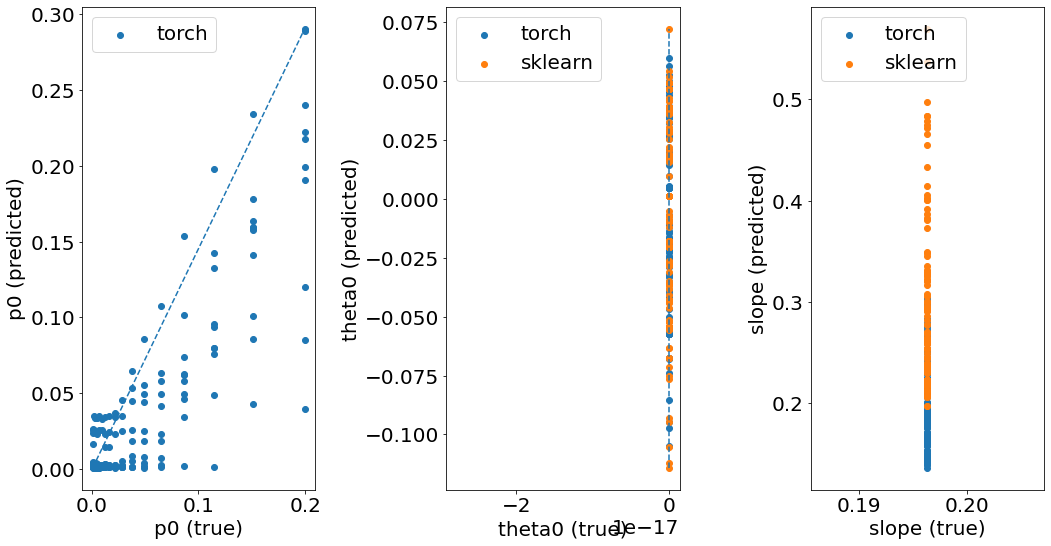

In [46]:
fig, axs = plt.subplots(1, 3, figsize=(15, 8))

axs[0].scatter(p0s_, p0_tos, label='torch')
axs[0].plot([min(p0s_), max(p0s_)], [min(p0_tos), max(p0_tos)], '--')
axs[0].set(xlabel='p0 (true)', ylabel='p0 (predicted)')
axs[0].legend(loc="upper left")

axs[1].scatter(p0s_, theta0_tos, label='torch')
axs[1].scatter(p0s_, theta0_sks, label='sklearn')
axs[1].plot([min(p0s_), max(p0s_)], [min(theta0_sks), max(theta0_sks)], '--')
axs[1].set(xlabel='p0', ylabel='theta0 (predicted)')
axs[1].legend(loc="upper left")

axs[2].scatter(p0s_, wt_tos, label='torch')
axs[2].scatter(p0s_, wt_sks, label='sklearn')
axs[2].plot([min(p0s_), max(p0s_)], [min(wts_), max(wts_)], '--')
axs[2].set(xlabel='p0', ylabel='slope (predicted)')
axs[2].legend(loc="upper left")
plt.tight_layout();



### changing `theta0`


In [47]:
N_scan = 20
theta0s = theta_std * np.linspace(-1, 1, N_scan, endpoint=True)

p0s_, wts_, theta0s_, p0_tos, theta0_tos, theta0_sks, wt_tos, wt_sks = [], [], [], [], [], [], [], []

for theta0_ in theta0s:
    for i_CV in range(N_cv):
        theta, p, y = get_data(theta0=theta0_, seed=seed+i_CV)
        
        logistic_model, loss = fit_data(theta, y, verbose=False)
        logistic_model_sk, loss_SKL = fit_data_sklearn(theta, y, verbose=False)
        
        theta0_to, wt_to, p0_to = get_params(logistic_model, verbose=False)
        theta0_sk, wt_sk = get_params_sk(logistic_model_sk, verbose=False)
        
        p0s_.append(p0)
        theta0s_.append(theta0_)
        wts_.append(wt)
        p0_tos.append(p0_to)
        theta0_tos.append(theta0_to)
        theta0_sks.append(theta0_sk)
        wt_tos.append(wt_to)
        wt_sks.append(wt_sk)
    

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


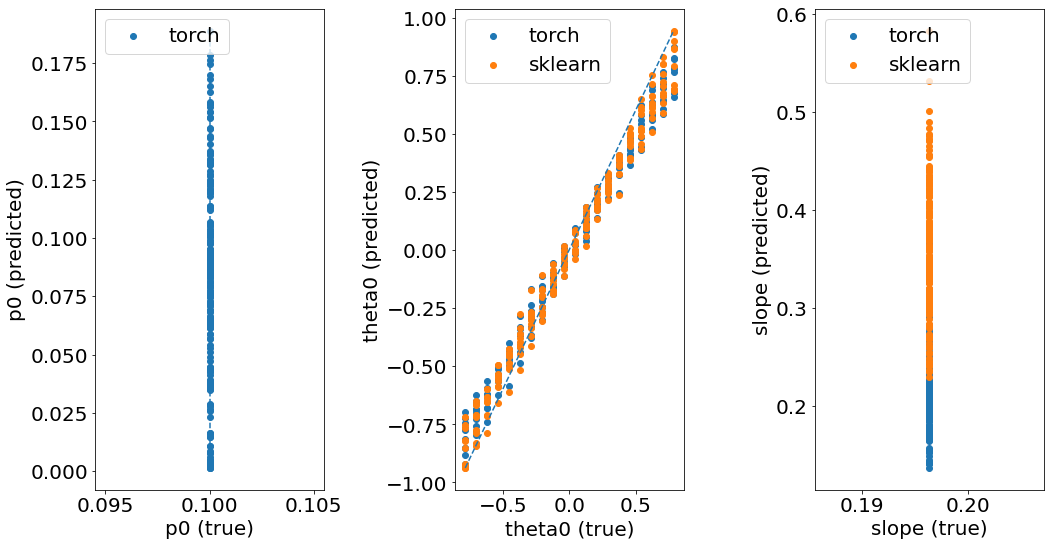

In [48]:
fig, axs = plt.subplots(1, 3, figsize=(15, 8))

axs[0].scatter(theta0s_, p0_tos, label='torch')
axs[0].plot([min(theta0s_), max(theta0s_)], [min(p0_tos), max(p0_tos)], '--')
axs[0].set(xlabel='theta0 (true)', ylabel='p0 (predicted)')
axs[0].legend(loc="upper left")

axs[1].scatter(theta0s_, theta0_tos, label='torch')
axs[1].scatter(theta0s_, theta0_sks, label='sklearn')
axs[1].plot([min(theta0s_), max(theta0s_)], [min(theta0_sks), max(theta0_sks)], '--')
axs[1].set(xlabel='theta0 (true)', ylabel='theta0 (predicted)')
axs[1].legend(loc="upper left")

axs[2].scatter(theta0s_, wt_tos, label='torch')
axs[2].scatter(theta0s_, wt_sks, label='sklearn')
axs[2].plot([min(theta0s_), max(theta0s_)], [min(wts_), max(wts_)], '--')
axs[2].set(xlabel='theta0 (true)', ylabel='slope (predicted)')
axs[2].legend(loc="upper left")
plt.tight_layout();



### changing `wt`


In [49]:
N_scan = 20
wts = wt * np.logspace(-1, 1, N_scan, base=10, endpoint=True)

p0s_, wts_, theta0s_, p0_tos, theta0_tos, theta0_sks, wt_tos, wt_sks = [], [], [], [], [], [], [], []

for wt_ in wts:
    for i_CV in range(N_cv):
        theta, p, y = get_data(wt=wt_, seed=seed+i_CV)
        
        logistic_model, loss = fit_data(theta, y, verbose=False)
        logistic_model_sk, loss_SKL = fit_data_sklearn(theta, y, verbose=False)
        
        theta0_to, wt_to, p0_to = get_params(logistic_model, verbose=False)
        theta0_sk, wt_sk = get_params_sk(logistic_model_sk, verbose=False)
        
        p0s_.append(p0)
        theta0s_.append(theta0)
        wts_.append(wt_)
        p0_tos.append(p0_to)
        theta0_tos.append(theta0_to)
        theta0_sks.append(theta0_sk)
        wt_tos.append(wt_to)
        wt_sks.append(wt_sk)
    

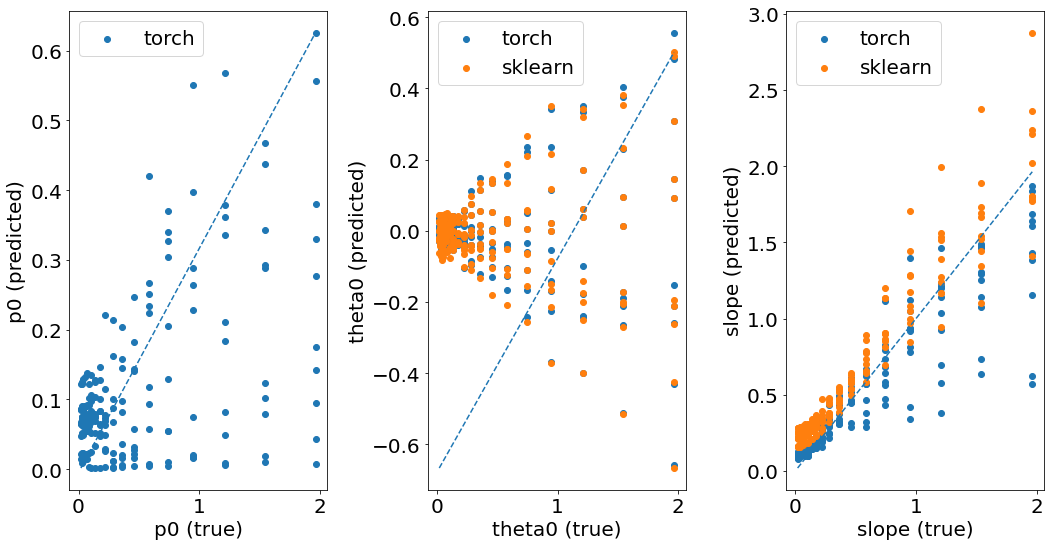

In [52]:
fig, axs = plt.subplots(1, 3, figsize=(15, 8))

axs[0].scatter(wts_, p0_tos, label='torch')
axs[0].plot([min(wts_), max(wts_)], [min(p0_tos), max(p0_tos)], '--')
axs[0].set(xlabel='slope (true)', ylabel='p0 (predicted)')
axs[0].legend(loc="upper left")

axs[1].scatter(wts_, theta0_tos, label='torch')
axs[1].scatter(wts_, theta0_sks, label='sklearn')
axs[1].plot([min(wts_), max(wts_)], [min(theta0_sks), max(theta0_sks)], '--')
axs[1].set(xlabel='slope (true)', ylabel='theta0 (predicted)')
axs[1].legend(loc="upper left")

axs[2].scatter(wts_, wt_tos, label='torch')
axs[2].scatter(wts_, wt_sks, label='sklearn')
axs[2].plot([min(wts_), max(wts_)], [min(wts_), max(wts_)], '--')
axs[2].set(xlabel='slope (true)', ylabel='slope (predicted)')
axs[2].legend(loc="upper left")
plt.tight_layout();